# 姓名：沈佩璇     受試日期：7/10

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 讀取檔案

In [3]:
def set_file():
    train = pd.read_csv(r'./Train_X.csv', encoding='cp950')
    train = train.sort_values(by=['日期']).reset_index(drop=True)
    train.drop(columns=['RTIME', '總市值.億.'], inplace = True)
    
    test = pd.read_csv(r'./Test_X.csv', encoding='cp950')
    test = test.sort_values(by=['日期']).reset_index(drop=True)
    test.drop(columns=['RTIME', '總市值.億.'], inplace = True)
    
    price= pd.read_csv(r'./Train_Y.csv', encoding='cp950')    
    price = price.sort_values(by=['日期']).reset_index(drop=True)
    maxnum = price['Target_Y'].max()
    minnum = price['Target_Y'].min()
    
    stock_list = pd.read_csv(r'./CorpInfo_2014.csv', encoding='utf8')
    stock_list['股票代號'] = stock_list['股票代號'].astype(str)
    return train, test, price, stock_list, maxnum, minnum
train, test, price, stock_list, maxnum, minnum = set_file()

# 畫出圖形，以cusum判斷是否有結構性轉變

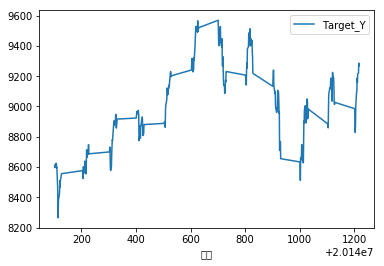

In [4]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import breaks_cusumolsresid

price.plot(kind='line',x='日期',y='Target_Y')
plt.show()

## H0為無結構性轉變, 結果為0.58，不拒絕H0

In [5]:
arma_mod1 = sm.tsa.ARMA(price['Target_Y'], (1,0)).fit(disp=False)
resid = arma_mod1.resid
breaks_cusumolsresid(resid, ddof=0)

C:\Users\user\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\user\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\user\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array i

(0.7741008874886407, 0.5867946306199794, [(1, 1.63), (5, 1.36), (10, 1.22)])

## 利用train、test整理出兩種表格：將"上市的股票資料依照市值加總後做成的指標"。index 皆為日期，column 皆為各種指標

In [6]:
# 先將上市股票跟其他指標做分類
stock_code = stock_list['股票代號'].unique()
stock_train = train[train['股票代號'].isin(stock_code)]
nonstock_train = train[~train['股票代號'].isin(stock_code)]

stock_test = test[test['股票代號'].isin(stock_code)]
nonstock_test = test[~test['股票代號'].isin(stock_code)]

# 先依各比重算加權總合
def sum_index(df1, stock_list):  # df1 放 stock  
    df1 = df1.dropna(subset=['市值比重...'])
    sum_index = df1[['日期', '股票代號', '股票名稱']]
    df1 = df1.dropna(subset=['市值比重...'])
    weigh_index = ['最高價', '最低價', '收盤價', '漲跌', '漲幅...', '振幅...', '成交量', '成交筆數', '成交金額.千.', '均張', '成交量變動...',
                  '均張變動...', '股本.百萬.', '本益比', '股價淨值比', '本益比.近四季.', '週轉率...', '成交值比重...', '成交值比重...',
                  '漲跌停', '均價', '成交量.股.']
    for item in weigh_index:
        df1[item] = df1['市值比重...']*df1[item]
    df1 = df1.groupby(['日期']).sum()
    return df1

    
# 將非上市股票，將在各column加上名稱。 ex: "{}"最高價.format(股票名稱)  的概念, 日期變成唯一值
def pivot_table(df2):    
    nonstock = df2['股票名稱'].unique()
    colname = df2.columns
    result = df2[['日期']].drop_duplicates()
    for item in nonstock:
        temp = df2[df2['股票名稱']==item]
        temp.drop(columns=['股票代號', '股票名稱'], inplace = True)
        temp.columns = [temp.columns[0]] + [item + str(col) for col in temp.columns[1:]]
        result = pd.merge(result, temp, how = 'left',on = ['日期'])
    return result

# 將表格合併
def merge_stock_nonstock(table1, table2):
    final = pd.merge(table1, table2, how = 'outer', on = ['日期'])
    final = final.sort_values(by=['日期']).reset_index(drop=True)
    return final

train =  merge_stock_nonstock(sum_index(stock_train, stock_list), pivot_table(nonstock_train))
train = train.dropna(thresh=237,axis='columns')
test = merge_stock_nonstock(sum_index(stock_test, stock_list), pivot_table(nonstock_test))
test = test.dropna(thresh=10,axis='columns')

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# 把所有變數normalize

In [7]:
from sklearn import preprocessing

def variables_normalized(result):
    x = result.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    date = result['日期']
    result = pd.DataFrame(x_scaled, columns = result.columns)
    result['日期'] = date
    return result

train = variables_normalized(train)
test = variables_normalized(test)
price = variables_normalized(price)

# 挑選features：因為沒有strcuture change，所以把train data set 以7:3 的比例切成train 跟 validation，利用train、validation各取前1000個較有效的features將它們取交集

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def features_selection(result, price):
    train_x = np.array(result.iloc[:166,1:])
    train_y = np.array(price.iloc[:166,-1])
    train_y = train_y.reshape((166,1))

    validation_x = np.array(result.iloc[166:,1:])
    validation_y = np.array(price.iloc[166:,-1])                      
    validation_y = validation_y.reshape((71,1))

    bestfeatures = SelectKBest(score_func=f_regression, k=1000)
    fit = bestfeatures.fit(train_x,train_y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(result.columns[1:])
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  
    train_top = pd.DataFrame(featureScores.nlargest(1000,'Score'))

    bestfeatures = SelectKBest(score_func=f_regression, k=1000)
    fit = bestfeatures.fit(validation_x,validation_y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(result.columns[1:])
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  
    validation_top = pd.DataFrame(featureScores.nlargest(1000,'Score'))

    features = pd.merge(train_top, validation_top, how='inner', on=['Specs'])
    
    return features

features = features_selection(train, price)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\user\Anaconda3\lib\site-packag

In [13]:
# 挑出在train 跟 test 跑模型所需的features 
features_name = features['Specs'].tolist()
def features_intersect(features_name, test_columns):
    intersetion = []
    for name in features_name:
        if name in test_columns:
            intersetion.append(name)
    return intersetion
train_top = train[features_intersect(features_name, test.columns)]
test_top = test[features_intersect(features_name, test.columns)]

# 運用 linear regression，結果不理想，MSE 比直接用過往平均值還爛

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
reg = linear_model.Ridge(alpha=0.5)
reg.fit(train_top[0:166].values ,price['Target_Y'][0:166].values)
y_predict = reg.predict(train_top[166:].values)
y_mean = price['Target_Y'][0:166].mean()

print('預測結果的MSE:', mean_squared_error(price['Target_Y'][166:].values, y_predict))
print('平均值的MSE:  ', mean_squared_error(price['Target_Y'][166:].values, np.full((71,1),y_mean)))

預測結果的MSE: 0.049368148440524576
平均值的MSE:   0.01831036780915802


# 利用CNN 模型，同時把feature間的交互作用、每個feature 的前五筆記錄下來，並跑模型

In [15]:
%env KERAS_BACKEND=tensorflow

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D

env: KERAS_BACKEND=tensorflow


In [16]:
# 切割資料，讓cnn 可以有包含自己的前五筆資料，同時也可以記錄feature 的交互關係
# 例：以n_steps 為3舉例
# feature1:[10, 20, 30, 40, 50, 60, 70, 80, 90]
# feature2:[15, 25, 35, 45, 55, 65, 75, 85, 95]
# [[10 15]
#  [20 25]
#  [30 35]]
# [[20 25]
#  [30 35]
#  [40 45]]
# [[30 35]
#  [40 45]
#  [50 55]]

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# 準備要 train 的 data
data = train_top[0:166].join(price['Target_Y'][0:166])
n_steps = 5
X, y = split_sequences(data.values, n_steps)
n_features = X.shape[2]

In [17]:
# 建cnn 模型模型
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(1))

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4, 32)             38304     
_________________________________________________________________
activation_1 (Activation)    (None, 4, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 32)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 38,337
Trainable params: 38,337
Non-trainable params: 0
_________________________________________________________________


In [41]:
# fit model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X, y, epochs=1000, verbose=1)

Epoch 1/1000
67/67 [==============================] - 0s 6ms/step - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 2/1000
67/67 [==============================] - 0s 327us/step - loss: 0.0231 - mean_squared_error: 0.0231
Epoch 3/1000
67/67 [==============================] - 0s 402us/step - loss: 0.0256 - mean_squared_error: 0.0256
Epoch 4/1000
67/67 [==============================] - 0s 342us/step - loss: 0.0224 - mean_squared_error: 0.0224
Epoch 5/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0201 - mean_squared_error: 0.0201
Epoch 6/1000
67/67 [==============================] - 0s 298us/step - loss: 0.0188 - mean_squared_error: 0.0188
Epoch 7/1000
67/67 [==============================] - 0s 372us/step - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 8/1000
67/67 [==============================] - 0s 313us/step - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 9/1000
67/67 [==============================] - 0s 298us/step - loss: 0.0185 - mean_squared_error: 0

67/67 [==============================] - 0s 283us/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 74/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 75/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 76/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 77/1000
67/67 [==============================] - 0s 327us/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 78/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 79/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 80/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 81/1000
67/67 [==============================] - 0s 357us/step - loss: 0.0067 - mean_squared_error: 0.00

67/67 [==============================] - 0s 283us/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 146/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 147/1000
67/67 [==============================] - 0s 298us/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 148/1000
67/67 [==============================] - 0s 357us/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 149/1000
67/67 [==============================] - 0s 313us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 150/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 151/1000
67/67 [==============================] - 0s 521us/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 152/1000
67/67 [==============================] - 0s 313us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 153/1000
67/67 [==============================] - 0s 342us/step - loss: 0.0042 - mean_squared_err

67/67 [==============================] - 0s 447us/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 217/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 218/1000
67/67 [==============================] - 0s 298us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 219/1000
67/67 [==============================] - 0s 298us/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 220/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 221/1000
67/67 [==============================] - 0s 223us/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 222/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 223/1000
67/67 [==============================] - 0s 313us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 224/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0028 - mean_squared_err

Epoch 288/1000
67/67 [==============================] - 0s 357us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 289/1000
67/67 [==============================] - 0s 357us/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 290/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 291/1000
67/67 [==============================] - 0s 328us/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 292/1000
67/67 [==============================] - 0s 372us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 293/1000
67/67 [==============================] - 0s 417us/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 294/1000
67/67 [==============================] - 0s 357us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 295/1000
67/67 [==============================] - 0s 357us/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 296/1000
67/67 [==============================] - 0s 372us/step - loss: 0.0024 - m

67/67 [==============================] - 0s 283us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 360/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 361/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 362/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 363/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 364/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 365/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 366/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 367/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0025 - mean_squared_err

Epoch 431/1000
67/67 [==============================] - 0s 327us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 432/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 433/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 434/1000
67/67 [==============================] - 0s 327us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 435/1000
67/67 [==============================] - 0s 432us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 436/1000
67/67 [==============================] - 0s 387us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 437/1000
67/67 [==============================] - 0s 298us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 438/1000
67/67 [==============================] - 0s 313us/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 439/1000
67/67 [==============================] - 0s 387us/step - loss: 0.0046 - m

67/67 [==============================] - 0s 238us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 503/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0012 - mean_squared_error: 0.0012  
Epoch 504/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0027 - mean_squared_error: 0.0027  
Epoch 505/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0012 - mean_squared_error: 0.0012  
Epoch 506/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 507/1000
67/67 [==============================] - 0s 223us/step - loss: 0.0012 - mean_squared_error: 0.0012  
Epoch 508/1000
67/67 [==============================] - 0s 223us/step - loss: 0.0014 - mean_squared_error: 0.0014  
Epoch 509/1000
67/67 [==============================] - 0s 208us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 510/1000
67/67 [==============================] - 0s 223us/step - loss: 0.0015 - mean_s

67/67 [==============================] - 0s 253us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 574/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 575/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 576/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 577/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 578/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 579/1000
67/67 [==============================] - 0s 281us/step - loss: 0.0023 - mean_squared_error: 0.0023  
Epoch 580/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 581/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0017 - mean_squared_e

67/67 [==============================] - 0s 253us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 645/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 646/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 647/1000
67/67 [==============================] - 0s 342us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 648/1000
67/67 [==============================] - 0s 223us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 649/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 650/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0011 - mean_squared_error: 0.0011  
Epoch 651/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 652/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0021 - mean_squared_e

67/67 [==============================] - 0s 268us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 716/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0011 - mean_squared_error: 0.0011  
Epoch 717/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0010 - mean_squared_error: 0.0010  
Epoch 718/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 719/1000
67/67 [==============================] - 0s 327us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 720/1000
67/67 [==============================] - 0s 327us/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 721/1000
67/67 [==============================] - 0s 298us/step - loss: 0.0025 - mean_squared_error: 0.0025  
Epoch 722/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 723/1000
67/67 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_err

67/67 [==============================] - 0s 268us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 786/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0013 - mean_squared_error: 0.0013  
Epoch 787/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 788/1000
67/67 [==============================] - 0s 372us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 789/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 790/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 791/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 792/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 793/1000
67/67 [==============================] - 0s 268us/step - loss: 9.7325e-04 - mean_squar

67/67 [==============================] - 0s 268us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 857/1000
67/67 [==============================] - 0s 268us/step - loss: 9.9845e-04 - mean_squared_error: 9.9845e-04
Epoch 858/1000
67/67 [==============================] - 0s 268us/step - loss: 9.2564e-04 - mean_squared_error: 9.2564e-04
Epoch 859/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 860/1000
67/67 [==============================] - 0s 298us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 861/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 862/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0025 - mean_squared_error: 0.0025  
Epoch 863/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 864/1000
67/67 [==============================] - 0s 313us/step - loss: 0.0012 

67/67 [==============================] - 0s 223us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 927/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 928/1000
67/67 [==============================] - 0s 417us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 929/1000
67/67 [==============================] - 0s 238us/step - loss: 8.9566e-04 - mean_squared_error: 8.9566e-04
Epoch 930/1000
67/67 [==============================] - 0s 238us/step - loss: 7.7718e-04 - mean_squared_error: 7.7718e-04
Epoch 931/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 932/1000
67/67 [==============================] - 0s 238us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 933/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 934/1000
67/67 [==============================] - 0s 253us/step - loss: 0.0014 - 

67/67 [==============================] - 0s 268us/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 996/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0016 - mean_squared_error: 0.0016  
Epoch 997/1000
67/67 [==============================] - 0s 283us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 998/1000
67/67 [==============================] - 0s 298us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 999/1000
67/67 [==============================] - 0s 268us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 1000/1000
67/67 [==============================] - 0s 268us/step - loss: 9.8155e-04 - mean_squared_error: 9.8155e-04


In [42]:
# 準備要 train 的 data
data = train_top[166:].join(price['Target_Y'][166:])
n_steps = 5
X, y = split_sequences(data.values, n_steps)
n_features = X.shape[2]
y_predict = model.predict(x=X)
print('預測結果的MSE:',mean_squared_error(price['Target_Y'][170:].values, y_predict))
print('平均值的MSE:  ', mean_squared_error(price['Target_Y'][170:].values, np.full((67,1),y_mean)))

預測結果的MSE: 0.0060461450785058496
平均值的MSE:   0.0193054256307064


In [43]:
# 準備要 test 的 data
data = train_top[-4:].append(test_top)
data['y'] = ' '
X, y = split_sequences(data.values, n_steps)
y_predict = model.predict(x=X)
y_predict

array([[0.64315784],
       [0.5978205 ],
       [0.5978205 ],
       [0.55062234],
       [0.41076514],
       [0.41076514],
       [0.3194706 ],
       [0.31787792],
       [0.44686577],
       [0.44686577]], dtype=float32)

In [44]:
# 還原 y_predict
y_predict * (maxnum - minnum) + minnum

array([[9103.602],
       [9044.451],
       [9044.451],
       [8982.872],
       [8800.401],
       [8800.401],
       [8681.291],
       [8679.213],
       [8847.502],
       [8847.502]], dtype=float32)